In [1]:
mesh_file = '../SSM_Grid/Salish_Sea_Shelf_top_0.2_DZ_10_3_16.2dm'
kb = 11
p_sigma = 1.5

restart_file = '/home/benr/wqmodels/ssm/unionph1/ramp/hyd/re_000006.dat'
restart_date = '2014-01-01'
run_name = 'unionph1'

validation_span_days = 20

import os
import os.path as path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fvcom.grid import FvcomGrid
from fvcom.depth import DepthCoordinate
from fvcom.state import FvcomState

import db
import validation_util as vu

In [2]:
grid = FvcomGrid.from_mesh(mesh_file)
dcoord = DepthCoordinate.from_asym_sigma(kb, grid, p_sigma)
state = FvcomState.read_restart_file(restart_file, grid, dcoord)

In [3]:
out_file = lambda name: path.join("notebook_outs", "fvcomic_" + run_name, name)
os.makedirs(path.dirname(out_file('foo')), exist_ok=True)

In [4]:
v = vu.FvcomStateValidator(state, restart_date, span=validation_span_days)
display(f'Validation range from {v.start_date} to {v.end_date}')

'Validation range from 2013-12-12 08:00:00+00:00 to 2014-01-21 08:00:00+00:00'

In [5]:
((temp_obs, salt_obs), station_nodes) = v.get_obsdata(('temp','salt'))
print(f'{len(temp_obs)} total temperature measurements')
print(f'{len(salt_obs)} total salinity measurements')
temp_obs.head()

21322 total temperature measurements
13631 total salinity measurements


,datetime,depth,value,location_id,cast_id,parameter_id,description,geom,node,tdiff
id,,,,,,,,,,
20006014,2013-12-12 08:00:00+00:00,1.145,9.60,PointWilliams,None,temp,Point Williams,POINT (544695.723 5265030.897),10977,20 days 00:00:00
20006015,2013-12-12 08:15:00+00:00,1.144,9.59,PointWilliams,None,temp,Point Williams,POINT (544695.723 5265030.897),10977,19 days 23:45:00
20006016,2013-12-12 08:30:00+00:00,1.147,9.58,PointWilliams,None,temp,Point Williams,POINT (544695.723 5265030.897),10977,19 days 23:30:00
20006017,2013-12-12 08:45:00+00:00,1.145,9.60,PointWilliams,None,temp,Point Williams,POINT (544695.723 5265030.897),10977,19 days 23:15:00
20006018,2013-12-12 09:00:00+00:00,1.139,9.60,PointWilliams,None,temp,Point Williams,POINT (544695.723 5265030.897),10977,19 days 23:00:00


In [6]:
temp_obs_filtered = v.filter_best(temp_obs)
salt_obs_filtered = v.filter_best(salt_obs)
temp_obs_filtered.head()

,datetime,depth,value,location_id,cast_id,parameter_id,description,geom,node,tdiff
id,,,,,,,,,,
20007934,2014-01-01 08:00:00+00:00,1.204000,8.920000,PointWilliams,None,temp,Point Williams,POINT (544695.723 5265030.897),10977,0 days 00:00:00
20596842,2014-01-01 08:00:00+00:00,5.036000,8.860000,Dockton,None,temp,Dockton Park,POINT (541267.236 5246741.441),13399,0 days 00:00:00
20596852,2014-01-01 09:15:00+00:00,6.346000,8.940000,Dockton,None,temp,Dockton Park,POINT (541267.236 5246741.441),13399,0 days 01:15:00
20597153,2014-01-03 14:15:00+00:00,8.937000,8.810000,Dockton,None,temp,Dockton Park,POINT (541267.236 5246741.441),13399,2 days 06:15:00
25093871,2014-01-16 20:14:11.999990+00:00,2.799064,8.684387,HC_TW,03ad307d-5815-47a4-837b-9c61870d7d73,temp,Twanoh ORCA Buoy,POINT (499373.416 5246837.904),13869,15 days 12:14:11.999990


In [7]:
# Group by cast
dfs = [v.process_cast(c, group) for c,group in temp_obs_filtered.groupby('cast_id')]
# Handle the observations that aren't part of a (large enough) cast
dfs.append(v.process_nocast(temp_obs_filtered.loc[temp_obs_filtered['cast_id'].isna()]))

temp_validation_df = pd.concat(dfs, ignore_index=True)
del dfs
temp_validation_df.to_csv(out_file("temp_validation.csv"), index=False)
temp_validation_df

,location,node,cast_id,datetime,t,depth,sigma,observed,model
0,HC_DB,11313,03a08ee0-812d-4aa7-9991-1a0c44f87811,2014-01-15 20:24:59.999990+00:00,0,4.370949,2,8.614264,6.850812
1,HC_DB,11313,03a08ee0-812d-4aa7-9991-1a0c44f87811,2014-01-15 20:24:59.999990+00:00,0,9.161733,3,8.689141,8.191298
2,HC_DB,11313,03a08ee0-812d-4aa7-9991-1a0c44f87811,2014-01-15 20:24:59.999990+00:00,0,15.066162,4,8.778414,9.763619
3,HC_DB,11313,03a08ee0-812d-4aa7-9991-1a0c44f87811,2014-01-15 20:24:59.999990+00:00,0,21.898361,5,8.785777,10.164551
4,HC_DB,11313,03a08ee0-812d-4aa7-9991-1a0c44f87811,2014-01-15 20:24:59.999990+00:00,0,29.544315,6,8.763117,10.262900
...,...,...,...,...,...,...,...,...,...
355,SEQ002,4030,fabd8b21-c346-4d90-a219-8ca57f936e38,2014-01-06 18:49:03+00:00,0,18.807880,10,7.042125,7.289508
356,PointWilliams,10977,NaN,2014-01-01 08:00:00+00:00,0,1.204000,0,8.920000,10.245914
357,Dockton,13399,NaN,2014-01-01 08:00:00+00:00,0,5.036000,3,8.860000,7.944817
358,Dockton,13399,NaN,2014-01-01 09:15:00+00:00,0,6.346000,4,8.940000,9.117120


In [8]:
# Group by cast
dfs = [v.process_cast(c, group) for c,group in salt_obs_filtered.groupby('cast_id')]
# Handle the observations that aren't part of a (large enough) cast
dfs.append(v.process_nocast(salt_obs_filtered.loc[salt_obs_filtered['cast_id'].isna()]))

salt_validation_df = pd.concat(dfs, ignore_index=True)
del dfs
salt_validation_df.to_csv(out_file("salt_validation.csv"), index=False)
salt_validation_df

,location,node,cast_id,datetime,t,depth,sigma,observed,model
0,HC_DB,11313,03a08ee0-812d-4aa7-9991-1a0c44f87811,2014-01-15 20:24:59.999990+00:00,0,4.370949,2,29.646319,27.290794
1,HC_DB,11313,03a08ee0-812d-4aa7-9991-1a0c44f87811,2014-01-15 20:24:59.999990+00:00,0,9.161733,3,29.750369,27.714125
2,HC_DB,11313,03a08ee0-812d-4aa7-9991-1a0c44f87811,2014-01-15 20:24:59.999990+00:00,0,15.066162,4,29.872136,28.708115
3,HC_DB,11313,03a08ee0-812d-4aa7-9991-1a0c44f87811,2014-01-15 20:24:59.999990+00:00,0,21.898361,5,29.992219,29.381226
4,HC_DB,11313,03a08ee0-812d-4aa7-9991-1a0c44f87811,2014-01-15 20:24:59.999990+00:00,0,29.544315,6,30.078568,29.645750
...,...,...,...,...,...,...,...,...,...
351,SEQ002,4030,fabd8b21-c346-4d90-a219-8ca57f936e38,2014-01-06 18:49:03+00:00,0,8.302178,6,31.713079,30.194811
352,SEQ002,4030,fabd8b21-c346-4d90-a219-8ca57f936e38,2014-01-06 18:49:03+00:00,0,10.657037,7,31.712506,30.186140
353,SEQ002,4030,fabd8b21-c346-4d90-a219-8ca57f936e38,2014-01-06 18:49:03+00:00,0,13.201363,8,31.712601,30.186119
354,SEQ002,4030,fabd8b21-c346-4d90-a219-8ca57f936e38,2014-01-06 18:49:03+00:00,0,15.921909,9,31.712900,30.152946


,Metric,R,RMSE,Bias,n
0,Temperature,0.672282,1.815790,0.181191,360
1,Salinity,0.418840,2.662445,-1.016007,356


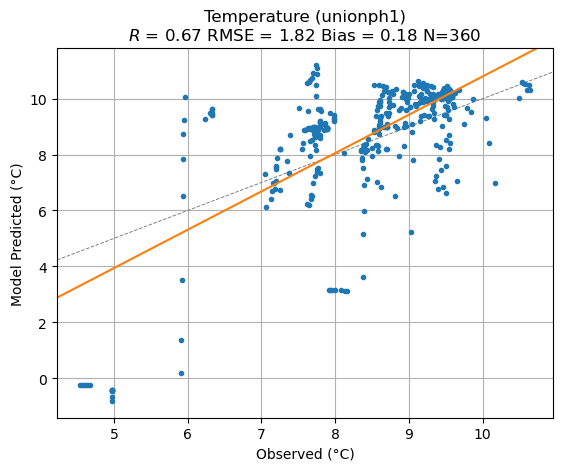

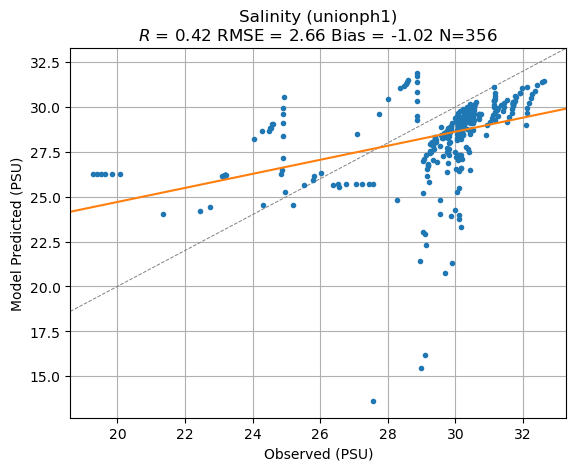

In [9]:
cum_stats = []
for pfx, label, data, unit in zip(('temp','salt'),
        ("Temperature","Salinity"),
        (temp_validation_df,salt_validation_df),
        ("\u00b0C","PSU")):
    if data.empty:
        continue
    fit, rsq, rmse, bias, n = vu.run_stats(data["observed"], data["model"])
    fig, ax = plt.subplots()
    vu.plot_fit(ax, data['observed'], data['model'], f'{label} ({run_name})', unit=unit)
    fig.savefig(out_file(f'{pfx}_validation.png'))
    cum_stats.append([label, rsq, rmse, bias, n])

display(pd.DataFrame(cum_stats, columns=["Metric","R","RMSE","Bias","n"]))